# Demand Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe
import seaborn as sns
from pylab import rcParams

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size
rcParams['figure.figsize'] = 8, 6

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Before we do anything, we want to have both sets in a format with 500 sales columns and 1 row for each day.

In [3]:
df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

In [4]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [5]:
from itertools import product, starmap


def storeitems():
    return product(range(1,51), range(1,11))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [6]:
df_train = sales_by_storeitem(df_train)
# for test set, we just fill y values with zeros (they won't be used anyway)
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


We combine data to prepare it for the model, and later split back into train and test set, not to repeat same transformations twice.

In [9]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [10]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


In [11]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

In [12]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index

In [13]:
df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

In [14]:
assert df_total.isnull().any().any() == False

We also want to append sales from previous day to each row, which we will then use as input data.

In [15]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret

    
def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [16]:
df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)

In [17]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2013-01-02 to 2018-03-31
Columns: 1020 entries, weekday_0 to item_50_store_10_sales_past_1
dtypes: bool(1), float64(1000), uint8(19)
memory usage: 14.7 MB


We need to make sure that stacked and not-stacked sales columns appar in the same order. We do this by sorting the names (as strings), which works fine because we only need 1 past day for the network (see regression models and their rolling mechanism if you are interested in rolling more than 1 past days of sales as input).

In [18]:
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [19]:
df_total = df_total.reindex(columns=new_cols)

In [20]:
assert df_total.isnull().any().any() == False

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

In [23]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [24]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [25]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 519 entries, item_10_store_10_sales_past_1 to month_12
dtypes: float64(500), uint8(19)
memory usage: 7.0 MB


In [27]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 500 entries, item_10_store_10_sales to item_9_store_9_sales
dtypes: float64(500)
memory usage: 7.0 MB


In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [29]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

For Keras, we need to make further transformations on input values:

In [30]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [31]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

Simple LSTM model:

In [32]:
basic_model = Sequential()
basic_model.add(LSTM(500, input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
basic_model.add(Dense(500))
basic_model.compile(loss='mean_absolute_error', optimizer='adam')

More complex model combining LSTM with convolutional layers:

In [34]:
inputs = Input(shape=(X_train_vals.shape[1], X_train_vals.shape[2]))
# top pipeline
top_lstm = LSTM(500)(inputs)
top_dense = Dense(500, activation='relu')(top_lstm)
top_dropout = Dropout(0.5)(top_dense)
# bottom pipeline
bottom_dense = Dense(500)(inputs)
bottom_conv1 = Conv1D(
    500, 
    kernel_size=1,
    input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])
)(bottom_dense)
bottom_conv2 = Conv1D(
    1000,
    kernel_size=50,
    padding='same',
    activation='relu'
)(bottom_conv1)
bottom_conv3 = Conv1D(
    500,
    kernel_size=10,
    padding='same',
    activation='relu'
)(bottom_conv2)
bottom_pooling = AvgPool1D(
    pool_size=60, 
    padding='same'
)(bottom_conv3)
bottom_reshape = Reshape(
    target_shape=[500]
)(bottom_conv3)
# concat output from both pipelines
final_concat = Concatenate()([top_dropout, bottom_reshape])
final_dense = Dense(500)(final_concat)
# compile and return
complex_model = Model(inputs=inputs, outputs=final_dense)
complex_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

Now we can fit the models:

In [54]:
basic_history = basic_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=40, 
    batch_size=30,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Epoch 1/40
49/49 - 1s - loss: 0.0712 - val_loss: 0.0700 - 520ms/epoch - 11ms/step
Epoch 2/40
49/49 - 0s - loss: 0.0717 - val_loss: 0.0708 - 486ms/epoch - 10ms/step
Epoch 3/40
49/49 - 0s - loss: 0.0753 - val_loss: 0.0857 - 240ms/epoch - 5ms/step
Epoch 4/40
49/49 - 1s - loss: 0.0785 - val_loss: 0.0706 - 544ms/epoch - 11ms/step
Epoch 5/40
49/49 - 1s - loss: 0.0758 - val_loss: 0.0738 - 812ms/epoch - 17ms/step
Epoch 6/40
49/49 - 0s - loss: 0.0764 - val_loss: 0.0688 - 496ms/epoch - 10ms/step
Epoch 7/40
49/49 - 0s - loss: 0.0762 - val_loss: 0.0678 - 305ms/epoch - 6ms/step
Epoch 8/40
49/49 - 0s - loss: 0.0746 - val_loss: 0.0647 - 368ms/epoch - 8ms/step
Epoch 9/40
49/49 - 0s - loss: 0.0747 - val_loss: 0.0647 - 429ms/epoch - 9ms/step
Epoch 10/40
49/49 - 0s - loss: 0.0737 - val_loss: 0.0614 - 462ms/epoch - 9ms/step
Epoch 11/40
49/49 - 0s - loss: 0.0740 - val_loss: 0.0622 - 325ms/epoch - 7ms/step
Epoch 12/40
49/49 - 1s - loss: 0.0729 - val_loss: 0.0593 - 506ms/epoch - 10ms/step
Epoch 13/40
49/49 -

In [55]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

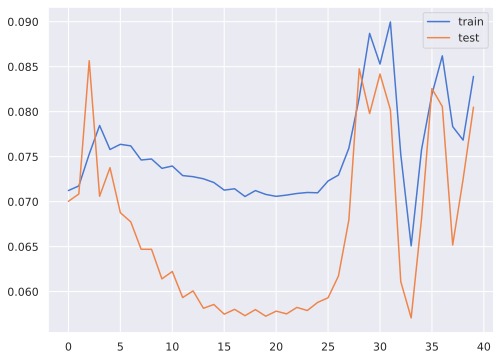

In [85]:
plot_history(basic_history)

In [38]:
complex_history = complex_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=20, 
    batch_size=70,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Epoch 1/20
21/21 - 12s - loss: 0.0382 - mape: 385.5209 - val_loss: 0.0139 - val_mape: 21.6262 - 12s/epoch - 589ms/step
Epoch 2/20
21/21 - 1s - loss: 0.0211 - mape: 405.8052 - val_loss: 0.0193 - val_mape: 32.4147 - 1s/epoch - 64ms/step
Epoch 3/20
21/21 - 1s - loss: 0.0122 - mape: 342.5009 - val_loss: 0.0097 - val_mape: 21.9208 - 1s/epoch - 66ms/step
Epoch 4/20
21/21 - 1s - loss: 0.0092 - mape: 314.5469 - val_loss: 0.0059 - val_mape: 16.2347 - 1s/epoch - 65ms/step
Epoch 5/20
21/21 - 1s - loss: 0.0110 - mape: 398.3917 - val_loss: 0.0063 - val_mape: 15.2710 - 1s/epoch - 65ms/step
Epoch 6/20
21/21 - 1s - loss: 0.0090 - mape: 325.3220 - val_loss: 0.0060 - val_mape: 16.5404 - 1s/epoch - 65ms/step
Epoch 7/20
21/21 - 1s - loss: 0.0077 - mape: 288.6919 - val_loss: 0.0068 - val_mape: 14.8723 - 1s/epoch - 65ms/step
Epoch 8/20
21/21 - 1s - loss: 0.0070 - mape: 426.4375 - val_loss: 0.0052 - val_mape: 14.4796 - 1s/epoch - 65ms/step
Epoch 9/20
21/21 - 1s - loss: 0.0065 - mape: 354.4620 - val_loss: 0.0

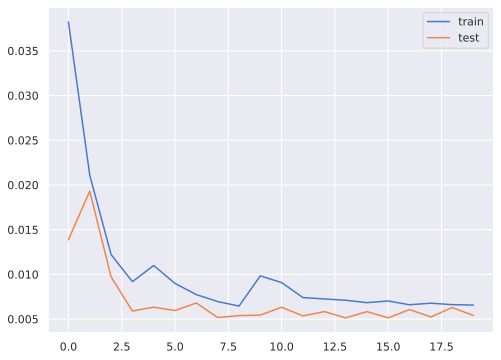

In [56]:
plot_history(complex_history)

## Evaluating model predictions

In [58]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values


def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]


def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

In [59]:
y_pred_basic, y_real = model_eval(basic_model, X_valid, y_valid)

1/1 [==============================] - 0s 31ms/step


In [60]:
y_pred_complex = model_eval(complex_model, X_valid, y_valid)[0]

1/1 [==============================] - 0s 19ms/step


In [61]:
# this is just for unscaling
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [62]:
basic_pred = unscale(y_pred_basic, scaler, template_df, toint=True)
complex_pred = unscale(y_pred_complex, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [63]:
basic_smapes = [vector_smape(basic_pred[col], real[col]) for col in basic_pred.columns]
complex_smapes = [vector_smape(complex_pred[col], real[col]) for col in complex_pred.columns]

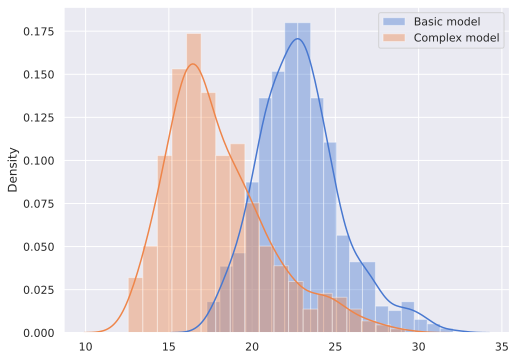

In [64]:
sns.distplot(basic_smapes, label='Basic model')
sns.distplot(complex_smapes, label='Complex model')
plt.legend(loc='upper right')
plt.savefig('smape_basic_vs_complex.svg')
plt.show()

Depending on training parameters, basic model can sometimes achieve results comparable to the complex one, however after uploading to Kaggle complex model achieved better (and more consistent) results.

In [65]:
describe(basic_smapes)

DescribeResult(nobs=500, minmax=(17.293133790494252, 32.07581490885227), mean=22.867708047963802, variance=6.268554278007772, skewness=0.6236052083468759, kurtosis=0.6473977702692615)

In [66]:
describe(complex_smapes)

DescribeResult(nobs=500, minmax=(12.563497260515083, 29.1931479763245), mean=17.92818418349839, variance=9.334326649046199, skewness=0.9530281532650646, kurtosis=0.7410945993317708)

### Visualizing model prediction
We will plot predictions for a sample store and item.

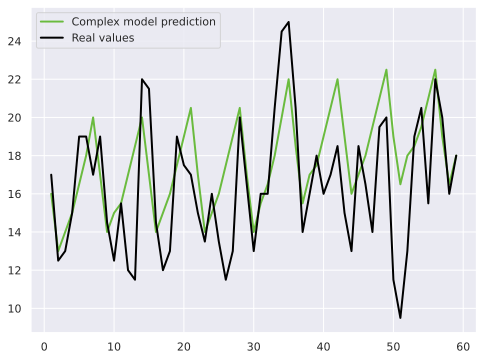

In [81]:
store, item = 1,1
plot_lengths = [60]
rolling_mean_windows = [2]  # to make plots more readable
storeitem_col = f'item_{item}_store_{store}_sales'

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(complex_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['green'],
             lw=2, 
             label='Complex model prediction')
    plt.plot(real[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2, 
             label='Real values')
    plt.legend(loc='upper left')
    plt.savefig(f'plot_prediction_{pl}_{mw}.svg')
    plt.show()

In [51]:
filename = 'neuralNetwork.sav'
filename1 = 'basicmodel.sav'

In [52]:
import pickle

In [53]:
pickle.dump(complex_model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......reshape
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.....

In [82]:
pickle.dump(basic_model, open(filename1, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-22 01:07:54           64
variables.h5                                   2023-02-22 01:07:54     27506512
config.json                                    2023-02-22 01:07:54         1810


In [83]:
pd.DataFrame(complex_pred).to_csv("file.csv")

In [84]:
pd.DataFrame(real).to_csv("file1.csv")